In [5]:
# Load Data

import pandas as pd
import matplotlib.pyplot as plt

file = '../datasets/snyk_and_advisory.csv'
final_df = pd.read_csv(file)

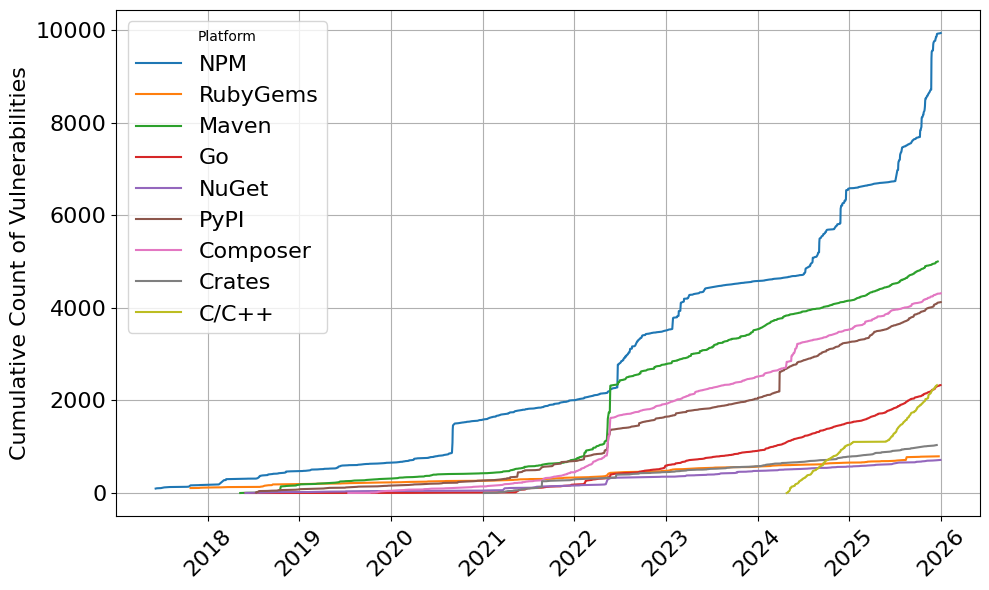

In [6]:


# Convert the 'Date' column to datetime format
final_df['Date'] = pd.to_datetime(final_df['Date'], format='%d %b %Y')

# Group by Date and Platform, then count occurrences
platform_counts = final_df.groupby(['Date', 'Platform']).size().reset_index(name='Count')

# Calculate cumulative counts for each platform
platform_counts['Cumulative Count'] = platform_counts.groupby('Platform')['Count'].cumsum()

# Plotting the cumulative counts over time for each platform
fig = plt.figure(figsize=(10, 6))
for platform in platform_counts['Platform'].unique():
    plt.plot(platform_counts[platform_counts['Platform'] == platform]['Date'], 
             platform_counts[platform_counts['Platform'] == platform]['Cumulative Count'], 
             linestyle='-', label=platform)

# plt.title('Cumulative Count of Vulnerabilities Over Time by Platform')
# plt.xlabel('Date')
plt.ylabel('Cumulative Count of Vulnerabilities', fontsize=16)
plt.xticks(rotation=45, fontsize=16)
plt.yticks(fontsize=16)
plt.legend(title='Platform', fontsize=16)
plt.grid()
plt.tight_layout()
plt.show()
# fig.savefig("vulnerability_trends.pdf", bbox_inches='tight')


,Platform,CWE,Vulnerability Count,Vulnerable Package Count
0,C/C++,CWE-122,222,105
2,C/C++,CWE-416,218,75
1,C/C++,CWE-125,201,93
3,C/C++,CWE-476,160,103
4,C/C++,CWE-787,140,64
7,Composer,CWE-79,1732,404
8,Composer,CWE-89,292,117
5,Composer,CWE-352,235,107
9,Composer,CWE-94,175,93
6,Composer,CWE-434,165,92


/tmp/ipykernel_3526388/1377756104.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=18)
/tmp/ipykernel_3526388/1377756104.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)
/tmp/ipykernel_3526388/1377756104.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=18)
/tmp/ipykernel_3526388/1377756104.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)
/tmp/ipykernel_3526388/1377756104.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=18)
/tmp/ipykernel_3526388/1377756104.py:55: UserWarning: FixedFormatter should only be used together wit

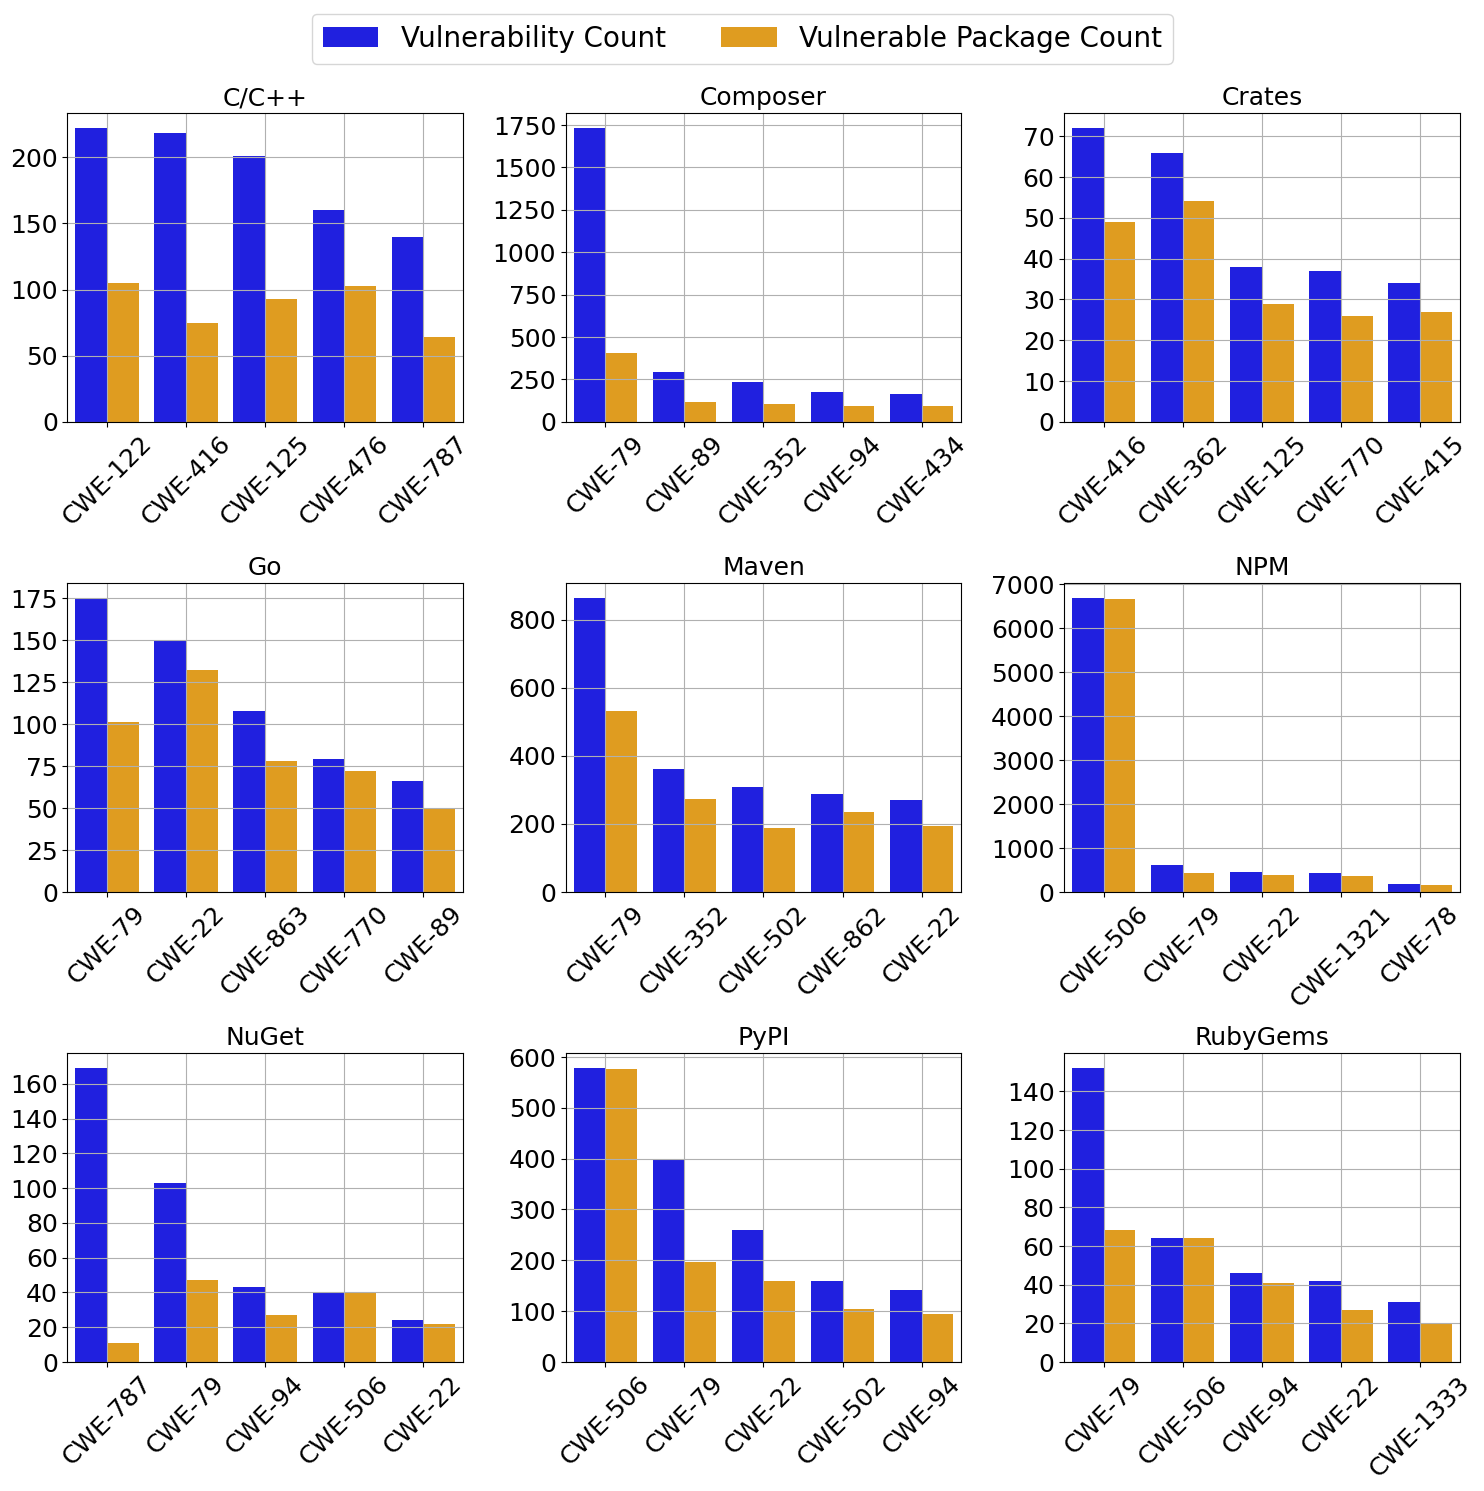

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

target_df = final_df

# Step 1: Group by Platform and CWE, count occurrences of each CWE
cwe_counts = target_df.groupby(['Platform', 'CWE']).size().reset_index(name='Vulnerability Count')

# Step 2: For each platform, find the top 5 CWEs based on count
top_cwes_per_platform = cwe_counts.groupby('Platform').apply(lambda x: x.nlargest(5, 'Vulnerability Count')).reset_index(drop=True)

# Step 3: Filter the original dataframe to only include rows where the CWE belongs to the top 5 for that platform
filtered_df = pd.merge(target_df, top_cwes_per_platform[['Platform', 'CWE', 'Vulnerability Count']], on=['Platform', 'CWE'])

# Step 4: Count the number of unique packages for each top CWE per platform
package_counts = filtered_df.groupby(['Platform', 'CWE', 'Vulnerability Count'])['Package'].nunique().reset_index(name='Vulnerable Package Count')
df_sorted = package_counts.groupby('Platform', group_keys=False).apply(lambda x: x.sort_values('Vulnerability Count', ascending=False))

display(df_sorted.head(20))
df = df_sorted

# Get the unique platforms
platforms = df['Platform'].unique()

# Set the number of columns for the subplot grid
n_cols = 3
n_rows = -(-len(platforms) // n_cols)  # This is to get the ceiling of division

# Set up the subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 5 * n_rows))

# Flatten the axes array to easily index in a loop
axes = axes.flatten()

# Plot each platform in a separate subplot
for i, platform in enumerate(platforms):
    ax = axes[i]
    platform_data = df[df['Platform'] == platform]

    # Melt the data to have 'Count' and 'Package_Count' in a single column
    plot_data = platform_data.melt(id_vars=['CWE', 'Platform'], value_vars=['Vulnerability Count', 'Vulnerable Package Count'], 
                                    var_name='Type', value_name='Value')

    # Plot the data using hue to separate counts
    sns.barplot(x='CWE', y='Value', hue='Type', data=plot_data, ax=ax, palette=['blue', 'orange'], dodge=True)

    # Set titles and labels
    ax.set_title(f'{platform}', fontsize=18)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.get_legend().remove()
    # ax.legend()
    ax.grid()
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=18)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)

# Remove any empty subplots if the number of platforms is not divisible by 3
for i in range(len(platforms), n_rows * n_cols):
    fig.delaxes(axes[i])

# Create a single legend at the top of the figure
handles, labels = axes[0].get_legend_handles_labels()  # Get handles and labels from the first subplot
fig.legend(handles, labels, loc='upper center', ncol=2, fontsize=20)  # Place legend at the top center

# Adjust layout and show the plot
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make space for the legend
plt.show()

# fig.savefig("top_cwes_package_vs_vulnerability_count.pdf", bbox_inches='tight')


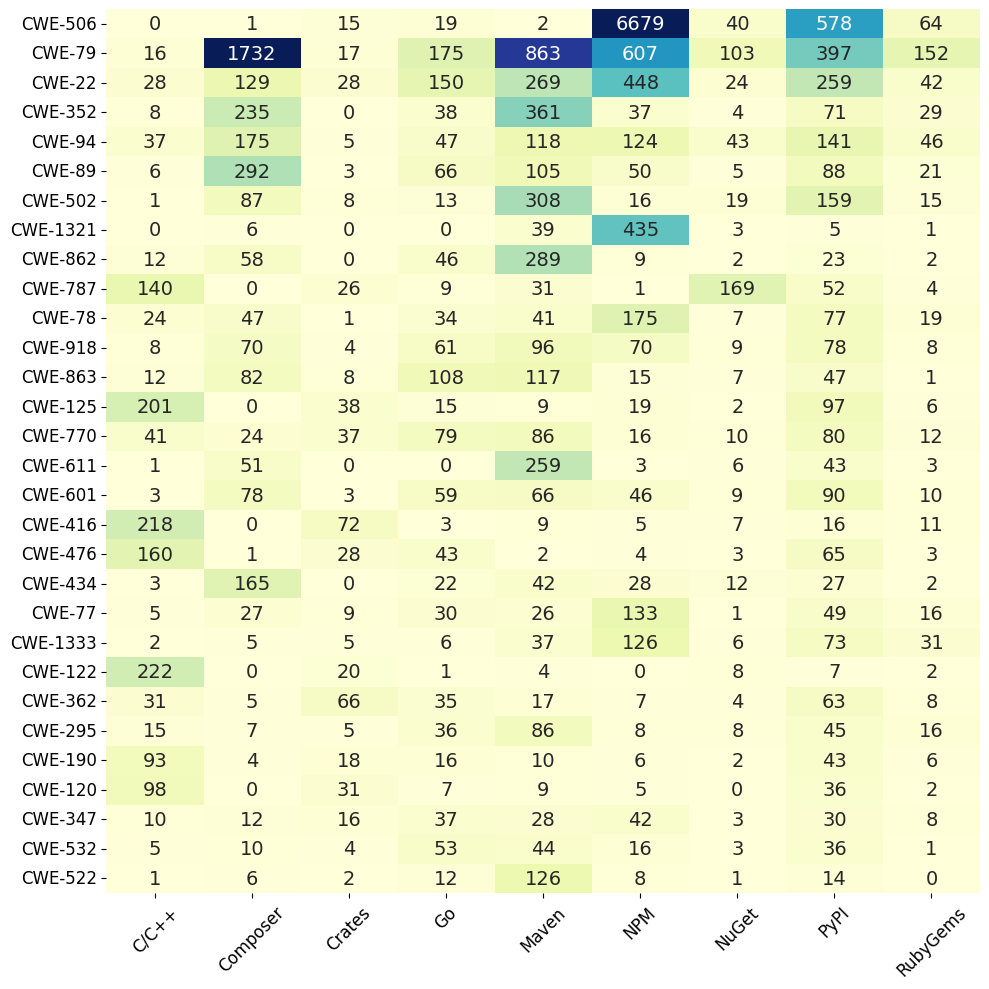

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Count occurrences of each CWE for each platform
cwe_platform_counts = final_df.groupby(['CWE', 'Platform']).size().unstack(fill_value=0)

# Select the top 30 CWEs based on total counts
top_cwes = cwe_platform_counts.sum(axis=1).nlargest(30).index
top_cwe_counts = cwe_platform_counts.loc[top_cwes]

# Create a heatmap with specified color range
fig = plt.figure(figsize=(10, 10))

# Set vmin and vmax according to your desired range
vmin = 0    # Minimum value for color mapping
vmax = 1000   # Maximum value for color mapping (adjust as needed)

sns.heatmap(
    top_cwe_counts,
    annot=True,
    fmt='d',
    cbar=False,
    cmap='YlGnBu',  # You can change this to other color maps like 'coolwarm', 'viridis', etc.
    cbar_kws={'label': 'Number of Vulnerabilities'},
    vmin=vmin,
    vmax=vmax,
    annot_kws={"size": 14}
)

# plt.title('Heatmap of Top 30 CWEs Against Different Platforms')
plt.xlabel('')
plt.ylabel('')
# Adjust tick parameters for larger ticks
plt.xticks(fontsize=12, rotation=45)  # Increase x-tick size
plt.yticks(fontsize=12, rotation=0)    # Increase y-tick size

plt.tight_layout()
plt.show()

# fig.savefig("top_30_cwe_vs_platform.pdf", bbox_inches='tight')


In [16]:
# Extract year from date and count vulnerabilities
final_df['Year'] = pd.to_datetime(final_df['Date']).dt.year
vulns_count = final_df.groupby(['Year', 'Platform']).size().reset_index(name='VulnCount')

# Count unique packages per year and platform
df_vuln = final_df.groupby(['Year', 'Platform'])['Package'].nunique().reset_index()

# Rename the columns for clarity
df_vuln.columns = ['Year', 'Platform', 'VulnPkgCount']

df_vuln

,Year,Platform,VulnPkgCount
0,2017,NPM,166
1,2017,RubyGems,63
2,2018,Go,1
3,2018,Maven,87
4,2018,NPM,273
...,...,...,...
59,2025,Maven,557
60,2025,NPM,3143
61,2025,NuGet,80
62,2025,PyPI,426


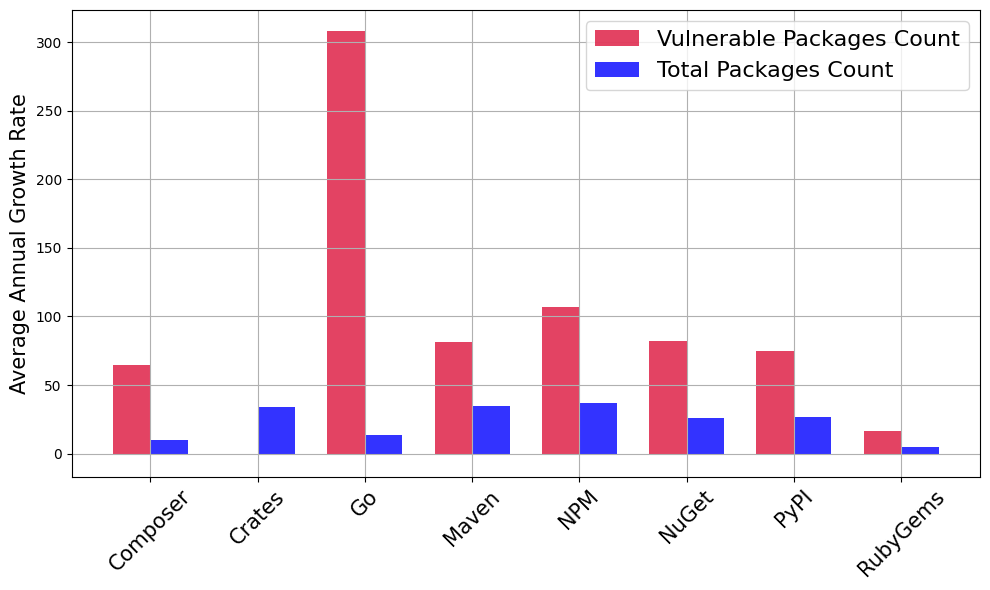

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
 
# Remove noise for 2020 of crate (first year high peak.)
df_vuln = df_vuln[~((vulns_count['Year'] == 2020) & (df_vuln['Platform'] == 'Crates'))]

data_total = {
    'Year': [2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026],
    'NPM': [415000, 647000, 941000, 1280000, 1620000, 2180000, 2730000, 4090000, 4880000, 5340000],  # NPM
    'Maven': [128000, 108000, 198000, 185000, 378000, 454000, 517000, 588000, 666000, 756000],         # Maven
    'PyPI': [83200, 118000, 174000, 232000, 311000, 418000, 508000, 501000, 601000, 739000],          # PyPI
    'NuGet': [79000, 111000, 145000, 200000, 265000, 296000, 412000, 472000, 543000, 610000],          # NuGet
    'Go': [862000, 811000, 1200000, 1820000, 274000, 460000, 422000, 486000, 511000, 698000],       # Go
    'Composer': [143000, 187000, 253000, 313000, 365000, 344000, 400000, 407000, 442000, 476000],         # Composer
    'RubyGems': [130000, 142000, 153000, 162000, 170000, 177000, 182000, 183000, 188000, 193000],         # RubyGems
    'Crates': [7900, 13100, 22600, 35700, 53500, 75200, 102000, 137000, 174000, 226000]                 # Cargo
}

# Assuming df_vuln is already defined
df_total = pd.DataFrame(data_total)

# Melt the total DataFrame to long format
df_total_melted = df_total.melt(id_vars=['Year'], var_name='Platform', value_name='TotalCount')

# Merge DataFrames
merged_df = pd.merge(df_vuln, df_total_melted, on=['Year', 'Platform'])

# Calculate the annual growth rate of vulnerabilities and total packages
merged_df['VulnAnnualGrowthRate'] = merged_df.groupby('Platform')['VulnPkgCount'].pct_change() * 100
merged_df['TotalAnnualGrowthRate'] = merged_df.groupby('Platform')['TotalCount'].pct_change() * 100

# Calculate average growth rates
average_growth = merged_df.groupby('Platform')[['VulnAnnualGrowthRate', 'TotalAnnualGrowthRate']].mean().reset_index()

# Filter out 'Crates' from average growth DataFrame
# average_growth = average_growth[average_growth['Platform'] != 'Crates']

# Prepare the plot for average growth rates
fig, ax = plt.subplots(figsize=(10, 6))

# Set bar positions
x = range(len(average_growth['Platform']))
bar_width = 0.35

# Create bars for average growth rates
ax.bar(x, average_growth['VulnAnnualGrowthRate'], width=bar_width, label='Vulnerable Packages Count', color='crimson', alpha=0.8)
ax.bar([p + bar_width for p in x], average_growth['TotalAnnualGrowthRate'], width=bar_width, label='Total Packages Count', color='blue', alpha=0.8)

# Add labels and title
ax.set_xticks([p + bar_width / 2 for p in x])
ax.set_xticklabels(average_growth['Platform'], fontsize=15, rotation=45)
ax.set_ylabel('Average Annual Growth Rate', fontsize=15)
# ax.set_title('Average Annual Growth Rate of Vulnerabilities and Total Packages by Platform')
ax.legend(fontsize=16)
ax.grid()

# Show the plot
plt.tight_layout()
plt.show()

# Save the figure if needed
# fig.savefig("average_growth_rate_without.pdf")


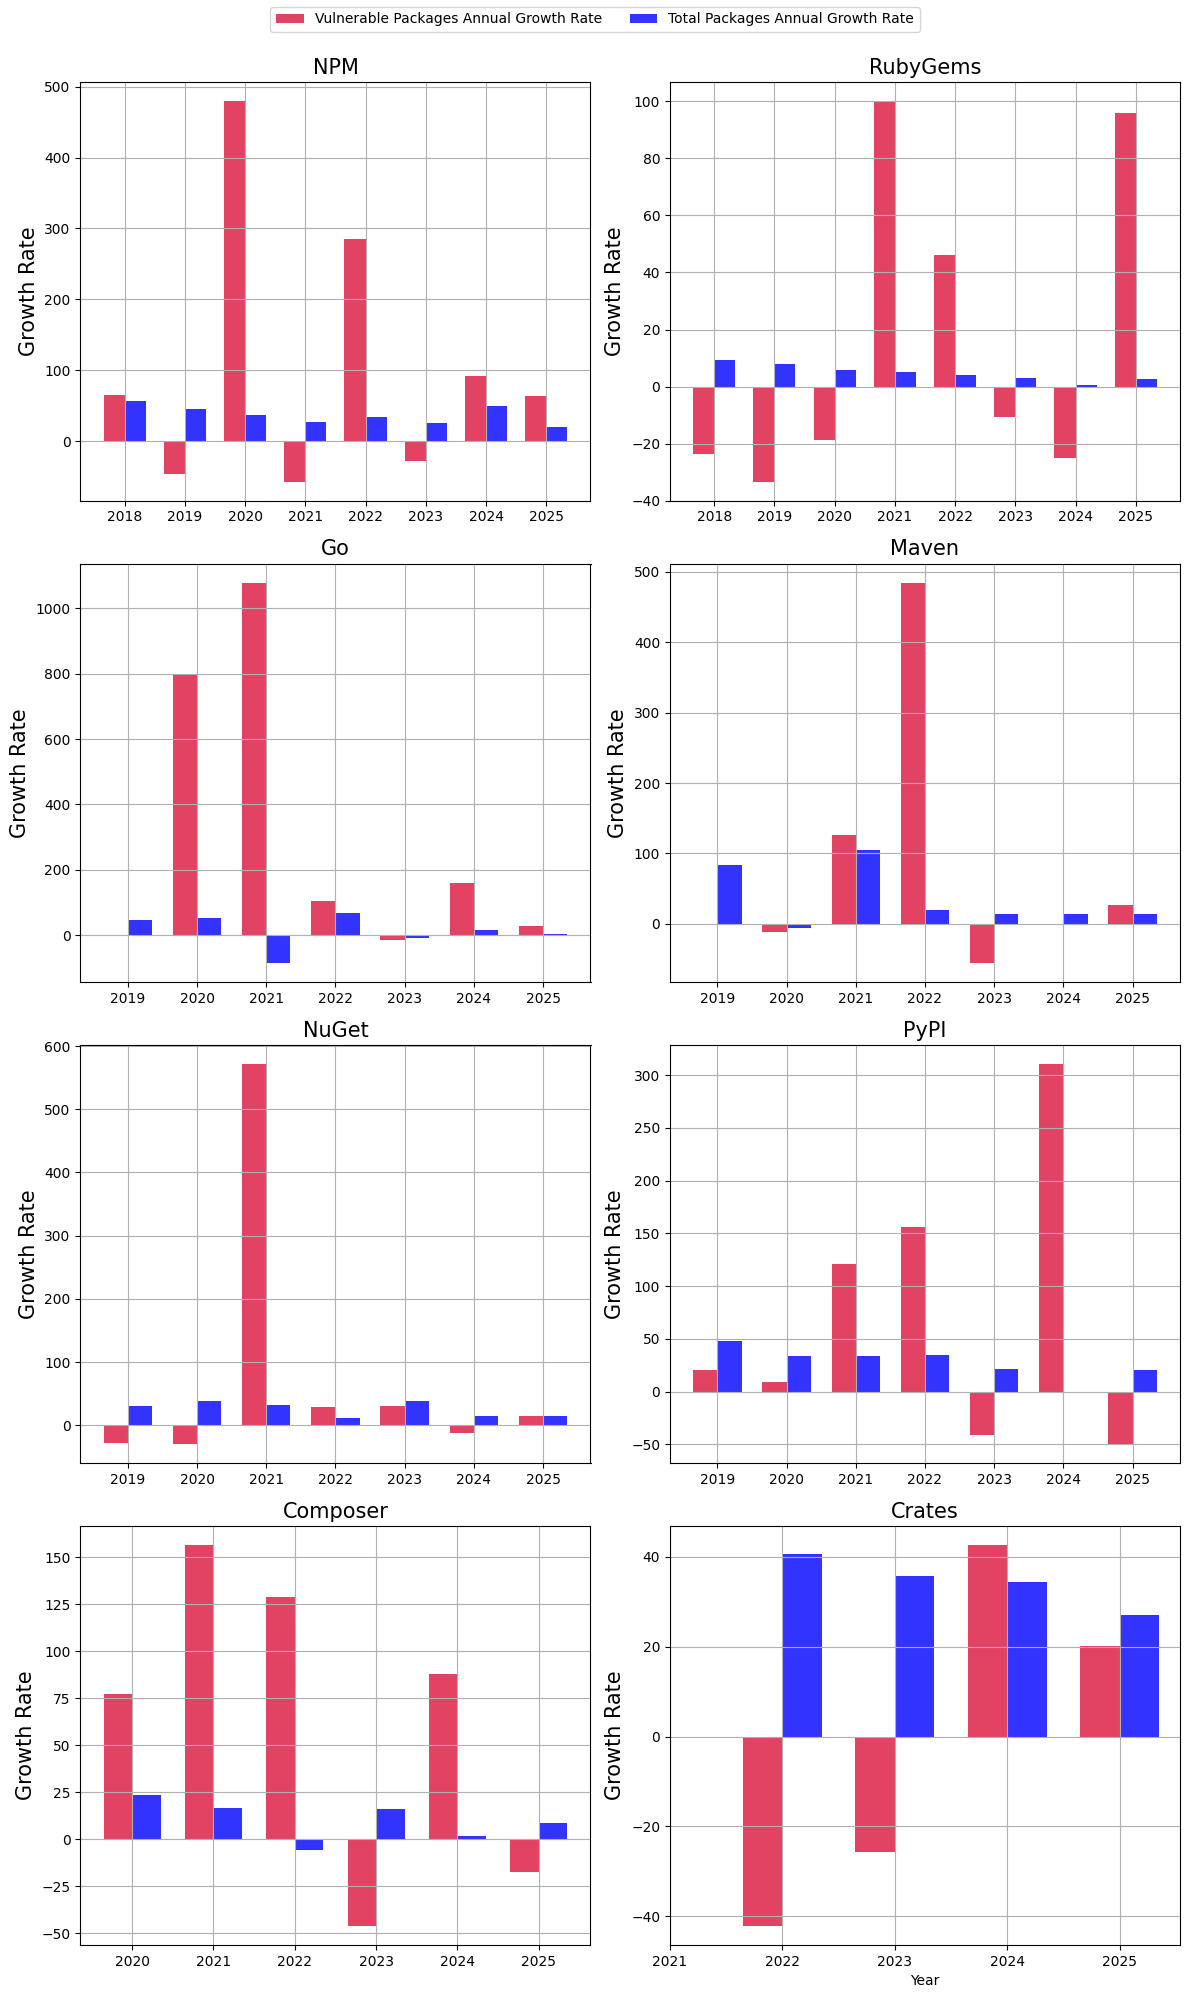

In [20]:
# Filter out the 'Crates' platform for the year 2022
df_vuln = df_vuln[~((vulns_count['Year'] == 2020) & (df_vuln['Platform'] == 'Crates'))]

import pandas as pd
import matplotlib.pyplot as plt

# Assuming df_vuln is defined elsewhere
# df_vuln = df_filtered

df_total = pd.DataFrame(data_total)

# Melt the total DataFrame to long format
df_total_melted = df_total.melt(id_vars=['Year'], var_name='Platform', value_name='TotalCount')

# Merge DataFrames
merged_df = pd.merge(df_vuln, df_total_melted, on=['Year', 'Platform'])

# Calculate the annual growth rate of vulnerabilities
merged_df['VulnAnnualGrowthRate'] = merged_df.groupby('Platform')['VulnPkgCount'].pct_change() * 100
merged_df['TotalAnnualGrowthRate'] = merged_df.groupby('Platform')['TotalCount'].pct_change() * 100

# Sum the total vulnerabilities per platform
total_vuln_count = merged_df.groupby('Platform')['VulnPkgCount'].sum().reset_index(name='TotalVulnCount')

# Combine results
result_df = pd.merge(merged_df[['Platform', 'Year', 'VulnAnnualGrowthRate', 'TotalAnnualGrowthRate']], 
                            total_vuln_count, 
                            on='Platform')

platforms = result_df['Platform'].unique()

num_platforms = len(platforms)

# Create subplots with two columns
cols = 2
rows = (num_platforms + cols - 1) // cols  # Calculate number of rows needed
fig, axes = plt.subplots(rows, cols, figsize=(12, 5 * rows), sharex=False)

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Create bar charts for each platform
for i, platform in enumerate(platforms):
    # Filter data for the current platform
    platform_data = result_df[result_df['Platform'] == platform]

    # Set bar positions
    bar_width = 0.35
    x = platform_data['Year']

    # Create bars
    axes[i].bar(x - bar_width/2, platform_data['VulnAnnualGrowthRate'], width=bar_width, label='Vulnerable Packages Annual Growth Rate', color='crimson', alpha=0.8)
    axes[i].bar(x + bar_width/2, platform_data['TotalAnnualGrowthRate'], width=bar_width, label='Total Packages Annual Growth Rate', color='blue', alpha=0.8)

    # Add labels and title
    axes[i].set_title(f'{platform}', fontsize=15)
    axes[i].set_ylabel('Growth Rate', fontsize=15)
    axes[i].grid()

# Hide any empty subplots if the number of platforms is odd
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Set common x-label
plt.xlabel('Year')
plt.xticks(x)

# Create a single legend at the top of the figure
handles, labels = axes[0].get_legend_handles_labels()  # Get handles and labels from the first subplot
fig.legend(handles, labels, loc='upper center', ncol=2)  # Place legend at the top center

# Adjust layout and show the plot
plt.tight_layout(rect=[0, 0, 1, 0.98])  # Adjust layout to make space for the legend
plt.show()

# fig.savefig("growth_rate_yearly.pdf")


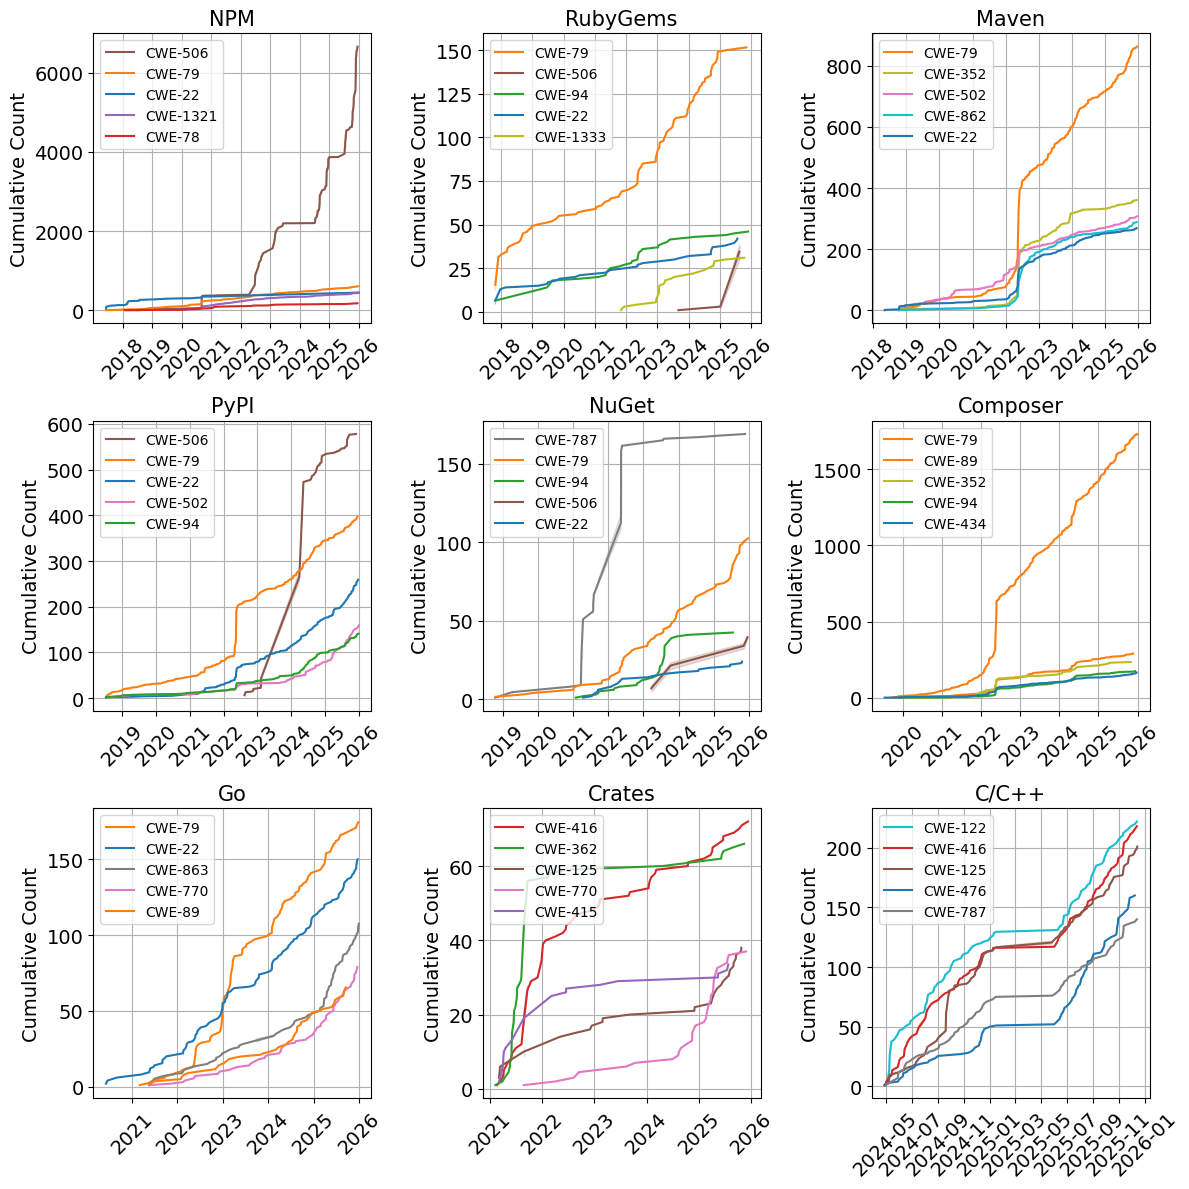

In [21]:
import numpy as np
import seaborn as sns


# Step 1: Find top 6 CWEs per platform
top_6_cwes_per_platform = final_df.groupby('Platform')['CWE'].value_counts().groupby(level=0).head(5).reset_index(name='Count')

# Step 2: Create a time-based cumulative count of CWEs
final_df['Date'] = pd.to_datetime(final_df['Date'])

# Merge top CWEs with main DataFrame
top_cwe_data = final_df.merge(top_6_cwes_per_platform[['Platform', 'CWE']], on=['Platform', 'CWE'])

# Step 3: Calculate cumulative count per CWE, per platform
top_cwe_data = top_cwe_data.sort_values('Date')
top_cwe_data['Cumulative_Count'] = top_cwe_data.groupby(['Platform', 'CWE'])['CWE'].cumcount() + 1

# Step 4: Set up the plot layout
platforms = top_cwe_data['Platform'].unique()
num_platforms = len(platforms)


# Get all unique CWEs and assign a consistent color palette
unique_cwes = top_cwe_data['CWE'].unique()
colors = sns.color_palette("tab10", len(unique_cwes))
cwe_color_map = dict(zip(unique_cwes, colors))

# Create subplots for each platform in 2 columns
# num_platforms = len(top_cwes['Platform'].unique())
ncols = 3
nrows = int(np.ceil(num_platforms / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, nrows * 4), sharex=False)

# fig, axes = plt.subplots(nrows=(num_platforms + 1) // 2, ncols=2, figsize=(14, 10), sharey=False)

# Step 5: Plot for each platform
for i, platform in enumerate(platforms):
    ax = axes[i // 3, i % 3]  # Determine subplot position
    platform_data = top_cwe_data[top_cwe_data['Platform'] == platform]

    # Sort the CWEs by the total counts in descending order for legend reordering
    sorted_cwes = platform_data.groupby('CWE')['CWE'].count().sort_values(ascending=False).index.tolist()


    # Create the lineplot for top 6 CWEs in the platform with cumulative count
    sns.lineplot(data=platform_data, x='Date', y='Cumulative_Count', hue='CWE', ax=ax, hue_order=sorted_cwes,  palette=cwe_color_map)

    ax.set_title(f"{platform}", fontsize=15)
    ax.set_xlabel('')
    ax.set_ylabel('Cumulative Count', fontsize=14)
    ax.tick_params(axis='x', rotation=45, labelsize=14)
    ax.tick_params(axis='y', labelsize = 14)
    ax.grid()
    ax.legend(loc='upper left')

# Check if the number of platforms is odd
# if num_platforms % 2 != 0:
#     # Hide the last empty subplot (if any)
#     fig.delaxes(axes[-1, -1])  # Remove the last subplot if empty

    # # Span the last plot across both columns to center it
    # last_ax = axes[-1, 0]
    # last_ax.set_position([0.25, last_ax.get_position().y0, 0.5, last_ax.get_position().height])


# Adjust layout
plt.tight_layout()
plt.show()
# fig.savefig("cwe_trends_per_platform.pdf", bbox_inches='tight')
